Per the UCI Machine Learning Repository, the following is the description of each of the variables:
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* X2: Gender (1 = male; 2 = female).
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others).
* X5: Age (year).
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005
    - X7 = the repayment status in August, 2005; . . .
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: 
        - -1 = pay duly
        - 1 = payment delay for one month
        - 2 = payment delay for two months; . . .
        - 8 = payment delay for eight months
        - 9 = payment delay for nine months and above.
* X12-X17: Amount of bill statement (NT dollar)
    - X12 = amount of bill statement in September, 2005
    - X13 = amount of bill statement in August, 2005; . . .
    - X17 = amount of bill statement in April, 2005. 
* X18-X23: Amount of previous payment (NT dollar).
    - X18 = amount paid in September, 2005
    - X19 = amount paid in August, 2005 . . .
    - X23 = amount paid in April, 2005.

Based on the descriptions, payment history is available for 6 months (April - September). Repayment status is available for 9+ months depending on the debtor.

There are some interesting variables (education level, marital status, etc.) that can be explored to determine their effects on payment history.

In [71]:
# Load the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm

# remove if not modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [19]:
# Load the dataset

credit = pd.read_excel('/home/bruce/Desktop/coding-projects/Other Datasets/default of credit card clients.xls', header=1)

Dataset is loaded without issues. Will complete an initial inspection of the dataset to determine datatypes, missing, etc.

In [20]:
# Check the head of the dataset
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [21]:
# Verify there is no missing data
credit.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [22]:
# Verify datatypes
credit.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

The following variables need to be changed:
* X2, X3, X4 = categorical
* X6-X11 = categorical

Initial inspection completed. Time to preprocess the data.

In [23]:
# Convert column names to lowercase to avoid errors
credit.columns = credit.columns.str.lower()
credit.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

I will verify that the entered values match the codes provided in the description (e.g., there are no erroneously entered values)

In [30]:
# Verify unique values before conversion
print("Unique values for education:", credit['education'].unique())
print("Unique values for marriage:", credit['marriage'].unique())
print("Unique values for pay_0:", credit['pay_0'].unique())
print("Unique values for pay_2:", credit['pay_2'].unique())
print("Unique values for pay_3:", credit['pay_3'].unique())
print("Unique values for pay_4:", credit['pay_4'].unique())
print("Unique values for pay_5:", credit['pay_5'].unique())
print("Unique values for pay_6:", credit['pay_6'].unique())

Unique values for education: [2 1 3 5 4 6 0]
Unique values for marriage: [1 2 3 0]
Unique values for pay_0: [ 2 -1  0 -2  1  3  4  8  7  5  6]
Unique values for pay_2: [ 2  0 -1 -2  3  5  7  4  1  6  8]
Unique values for pay_3: [-1  0  2 -2  3  4  6  7  1  5  8]
Unique values for pay_4: [-1  0 -2  2  3  4  5  7  6  1  8]
Unique values for pay_5: [-2  0 -1  2  3  5  4  7  8  6]
Unique values for pay_6: [-2  2  0 -1  3  6  4  7  8  5]


The following are issues based on the results of the unique values:
* There are erroneous values for education. The values should only be 1, 2, 3, or 4 and there are values of 0, 5, and 6.
* There are erroneous values for marriage. The values should only be 1, 2, or 3. There are values of 0
* Erroneous values for all pay columns. There are values of -2 and 0 entered. All other values are correct.

The following paper uses the dataset for ML modeling and discusses the variables in some detail; however, there is no mention of the erroneous values:
* Islam, S.R., Eberle, W., & Ghafoor, S.K. (2018). Credit Default Mining Using Combined Machine Learning and Heuristic Approach. ArXiv, abs/1807.01176.
* There is another paper cited on the UCI ML Repository, but it does not discuss the variables in detail

Regarding the erroneous values:
* Pay columns: Can assume -2 is either 'Pay Duly' (so -1) or can assume it is 'Delay 2 Months' (so 2)
* Education: Can assume all erroneous values are 'Others' (e.g., '4'), but the values entered as '0' may indicate 'No education'?
* Marriage: Can assume '0' is a mistaken binary entry (e.g., 'No') and change to Single ('2')

I will count the unique values to determine the potential impacts

In [40]:
# Summing the counts for each unique value for education
print("Counts for:", credit['education'].value_counts())
print('\n')

# Summing the counts for each unique value for marriage
print("Counts for:", credit['marriage'].value_counts())
print('\n')

# Summing the counts for each unique value for the pay columns
print("Counts for:", credit['pay_0'].value_counts())
print('\n')
print("Counts for:", credit['pay_2'].value_counts())
print('\n')
print("Counts for:", credit['pay_3'].value_counts())
print('\n')
print("Counts for:", credit['pay_4'].value_counts())
print('\n')
print("Counts for:", credit['pay_5'].value_counts())
print('\n')
print("Counts for:", credit['pay_6'].value_counts())
print('\n')

Counts for: education
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64


Counts for: marriage
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64


Counts for: pay_0
 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64


Counts for: pay_2
 0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: count, dtype: int64


Counts for: pay_3
 0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: count, dtype: int64


Counts for: pay_4
 0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: count, dtype: int64


Counts for: pay_5
 0    16947
-1     5539
-2     4546
 2     2626
 3

Based on the previous counts:
* Change all 0 values in the pay columns to -1 ('Pay Duly')
* Change all -2 values in the pay columns to 2 ('Delay 2 Months')
* There are only 54 values entered as 0 for marriage - will assume they are "No" and change to 2 ('Single')
* Will assume all erroneous values for education are 4 ('Others')

In [42]:
# List pay columns
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

# Change all 0 values to -1 in the pay columns
credit[pay_cols] = credit[pay_cols].replace(0, -1)

# Change all -2 values to 2 in the pay columns
credit[pay_cols] = credit[pay_cols].replace(-2, 2)

# Change all 0 values to 2 in the marriage column
credit['marriage'] = credit['marriage'].replace(0, 2)

# Change all 0, 5, 6 values to 4 in education column
credit['education'] = credit['education'].replace(0, 4)
credit['education'] = credit['education'].replace(5, 4)
credit['education'] = credit['education'].replace(6, 4)

Verify counts following changes:

In [43]:
# Summing the counts for each unique value for education
print("Counts for:", credit['education'].value_counts())
print('\n')

# Summing the counts for each unique value for marriage
print("Counts for:", credit['marriage'].value_counts())
print('\n')

# Summing the counts for each unique value for the pay columns
print("Counts for:", credit['pay_0'].value_counts())
print('\n')
print("Counts for:", credit['pay_2'].value_counts())
print('\n')
print("Counts for:", credit['pay_3'].value_counts())
print('\n')
print("Counts for:", credit['pay_4'].value_counts())
print('\n')
print("Counts for:", credit['pay_5'].value_counts())
print('\n')
print("Counts for:", credit['pay_6'].value_counts())
print('\n')

Counts for: education
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64


Counts for: marriage
2    16018
1    13659
3      323
Name: count, dtype: int64


Counts for: pay_0
-1    20423
 2     5426
 1     3688
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64


Counts for: pay_2
-1    21780
 2     7709
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: count, dtype: int64


Counts for: pay_3
-1    21702
 2     7904
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: count, dtype: int64


Counts for: pay_4
-1    22142
 2     7507
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: count, dtype: int64


Counts for: pay_5
-1    22486
 2     7172
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: count, dtype: int64


Counts for: pay_6
-1    22026
 2     7661
 3      184
 4       49


Erroneous values are handles, so time to convert sex, education, marriage, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6 to categorical with correct labels and verify change:

In [44]:
# Define mapping for categorical variables
education_map = {1: 'Graduate', 2: 'University', 3: 'High School', 4: 'Others'}
gender_map = {1: 'Male', 2: 'Female'}
marriage_map = {1: 'Married', 2: 'Single', 3: 'Others'}
pay_map = {
    -1: 'Pay Duly',
    1: 'Delay 1 Month',
    2: 'Delay 2 Months',
    3: 'Delay 3 Months',
    4: 'Delay 4 Months',
    5: 'Delay 5 Months',
    6: 'Delay 6 Months',
    7: 'Delay 7 Months',
    8: 'Delay 8 Months',
    9: 'Delay 9+ Months'
}

# Define category lists
education_cats = ['Graduate', 'University', 'High School', 'Others']
gender_cats = ['Male', 'Female']
marriage_cats = ['Married', 'Single', 'Others']
pay_cats = [
    'Pay Duly',
    'Delay 1 Month',
    'Delay 2 Months',
    'Delay 3 Months',
    'Delay 4 Months',
    'Delay 5 Months',
    'Delay 6 Months',
    'Delay 7 Months',
    'Delay 8 Months',
    'Delay 9+ Months'
]

# Apply mapping and categorical conversion in one step
credit['sex'] = credit['sex'].map(gender_map).astype('category')

credit['education'] = pd.Categorical(
    credit['education'].map(education_map),
    categories=education_cats,
    ordered=True
)

credit['marriage'] = credit['marriage'].map(marriage_map).astype('category')

# For pay columns: map AND convert with explicit categories/order
for pay_col in ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']:
    credit[pay_col] = pd.Categorical(
        credit[pay_col].map(pay_map),
        categories=pay_cats,
        ordered=True
    )

# Verify change to categorical
credit.dtypes

id                               int64
limit_bal                        int64
sex                           category
education                     category
marriage                      category
age                              int64
pay_0                         category
pay_2                         category
pay_3                         category
pay_4                         category
pay_5                         category
pay_6                         category
bill_amt1                        int64
bill_amt2                        int64
bill_amt3                        int64
bill_amt4                        int64
bill_amt5                        int64
bill_amt6                        int64
pay_amt1                         int64
pay_amt2                         int64
pay_amt3                         int64
pay_amt4                         int64
pay_amt5                         int64
pay_amt6                         int64
default payment next month       int64
dtype: object

In [45]:
# Verify categories
print("Education categories:", credit['education'].cat.categories.tolist())
print("Marriage categories:", credit['marriage'].cat.categories.tolist())
print("Gender categories:", credit['sex'].cat.categories.tolist())
print("Pay_0 categories:", credit['pay_0'].cat.categories.tolist())

Education categories: ['Graduate', 'University', 'High School', 'Others']
Marriage categories: ['Married', 'Others', 'Single']
Gender categories: ['Female', 'Male']
Pay_0 categories: ['Pay Duly', 'Delay 1 Month', 'Delay 2 Months', 'Delay 3 Months', 'Delay 4 Months', 'Delay 5 Months', 'Delay 6 Months', 'Delay 7 Months', 'Delay 8 Months', 'Delay 9+ Months']


In [46]:
# Verify no data was "lost" during conversion
credit.isna().sum()

id                            0
limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default payment next month    0
dtype: int64

Let's see how the data is distributed for each variable.

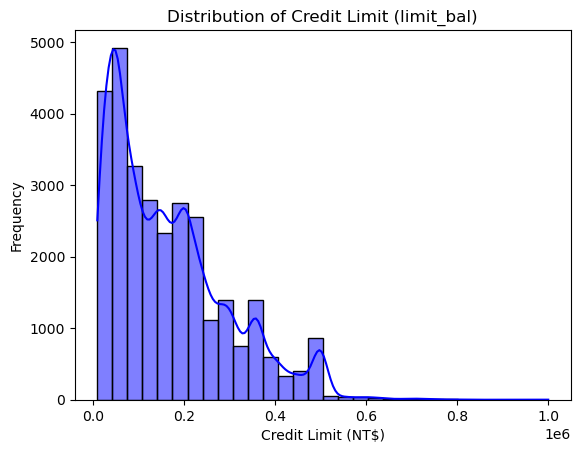

In [72]:
# limit_bal distribution
sns.histplot(credit['limit_bal'], bins = 30, kde = True, color = "blue", edgecolor = "black")
plt.title('Distribution of Credit Limit (limit_bal)')
plt.xlabel('Credit Limit (NT$)')
plt.ylabel('Frequency')
plt.show()

In [75]:
print("Skewness:", credit['limit_bal'].skew())

Skewness: 0.992866960519544


Distribution is left-skewed with a statistical skewness almost equal to 1. Square root transformation is the least aggressive. Let's see what a square root transformation will do to the skewness:

In [112]:
# Original limit_bal data
original = credit['limit_bal']

# Square root transformation
credit['limit_bal_sqrt'] = np.sqrt(original.max() + 1 - original)

# Print the statistical skewness for comparison
skew_sqrt = credit['limit_bal_sqrt'].skew()
print("limit_bal Square Root Skewness:", skew_sqrt)

limit_bal Square Root Skewness: -1.2708999763046513


That puts the skewness at the other end of the spectrum. Visualize for confirmation based on statistical skewness:

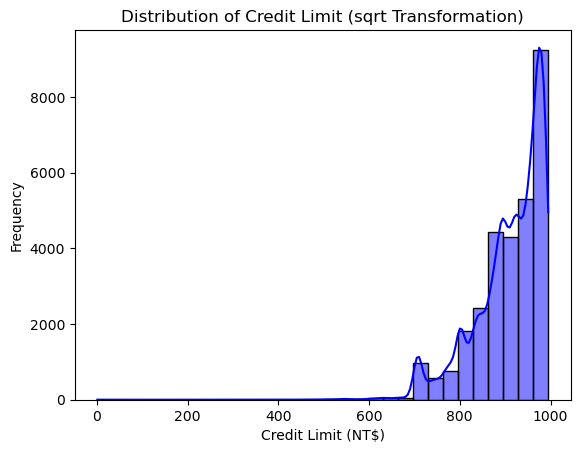

In [113]:
# limit_bal_sqrt distribution
sns.histplot(credit['limit_bal_sqrt'], bins = 30, kde = True, color = "blue", edgecolor = "black")
plt.title('Distribution of Credit Limit (sqrt Transformation)')
plt.xlabel('Credit Limit (NT$)')
plt.ylabel('Frequency')
plt.show()

Maybe see what a log transformation does?:

In [116]:
# limit_bal log transformation
credit['limit_bal_log'] = np.log1p(original.max() + 1 - original) # log(max - x + 1) to preserve order and avoid zeros

# Print the statistical skewness for comparison
skew_log = credit['limit_bal_log'].skew()
print("limit_bal Log Skewness:", skew_log)

limit_bal Log Skewness: -11.555222789368255


That creates a very significant right skew. It is best to keep the original data with the left skew and note the skewed distribution when reporting.

Let's continue determining the distribution of the remaining variables:

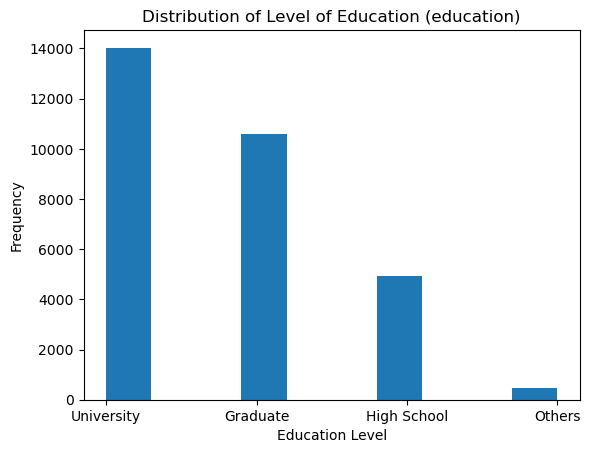

In [114]:
# Education level distribution
plt.hist(credit['education'])
plt.title('Distribution of Level of Education (education)')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.show()

Over half of those included in this dataset have a college education (university or graduate) with most having a university (bachelor?) level education.

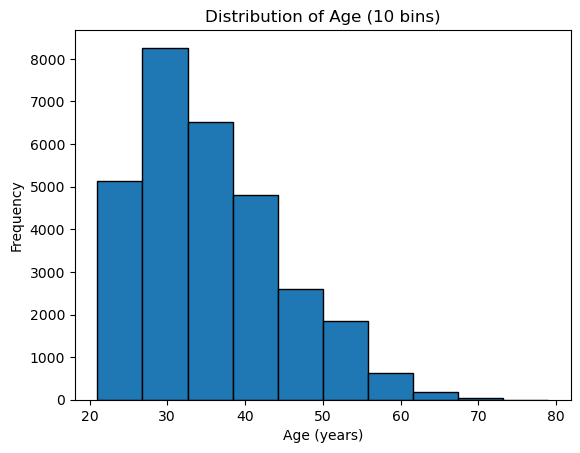

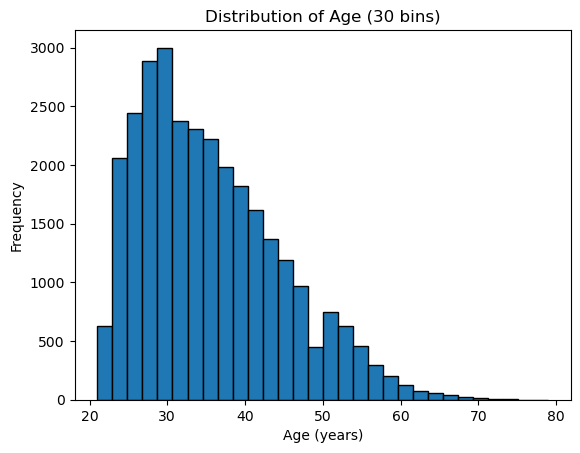

In [ ]:
# Distribution for age using 10 bins
plt.hist(credit['age'], bins = 10, edgecolor = 'black')
plt.title('Distribution of Age (10 bins)')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

# Distribution for age using 30 bins
plt.hist(credit['age'], bins = 30, edgecolor = 'black')
plt.title('Distribution of Age (30 bins)')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

In [89]:
print("Skewness:", credit['age'].skew())

Skewness: 0.7322458687830562


Majority are younger (</= 40 years). There is a slight left skew.

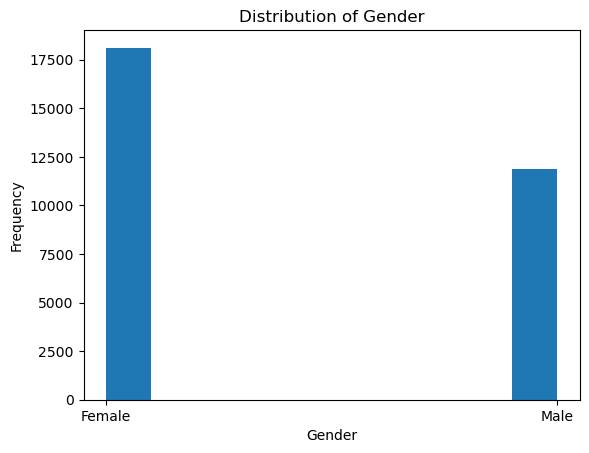

In [90]:
# Distribution for gender
plt.hist(credit['sex'])
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.suptitle('Distribution for Pay')
plt.

Data is cleaned, wrangled, and visualized. Time to start modeling. 

I will start with statistical significance testing using linear regression with amount of given credit as the target variable (since the target variable is continuous). I will include education, sex, and marriage in the initial model as a "baseline" prior to including age and the pay status. The initial model will be non-transformed data.

In [91]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage'

# Create the model
esm_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29993
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                      1.5236e+10
Method:                          IRLS   Log-Likelihood:            -3.9427e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.5699e+14
Time:                        02:22:21   Pearson chi2:                 4.57e+14
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09975
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

* The "baseline" credit limit is NT$240,800 +/- 1630.33 when the client is a married female with a graduate level of education.
* Being a male is associated with a credit limit that is NT$6728.04 +/- 1458.19 less compared to females and assuming all other variables are constant. 
* Having a university level of education is associated with a credit limit NT$71,080 +/- 1603.24 less compared to those with a graduate level of education and assuming all other variables are constant.
* Having a high school level of education is associated with a credit limit NT$94,750 +/- 2161.44 less compared to those with a graduate level of education and assuming all other variables are constant. 
* Having an education level classified as "other" is associated with a credit limit NT$37,250 +/- 5835.94 less than those with a graduate level of education and assuming all other variables are constant. 
* Being single is associated with a credit limit NT$38,500 +/- 1460.26 less than those that are married, assuming all other variables are constant. 
* Those that have a marriage status categorised as "Others" have a credit limit NT$73,250 +/- 6953.36 less than those that are married, assuming all other variables are constant.
* All coefficients are statistically significant as the p-values are <.0001 and none of the 95% confidence intervals include 0.
* The R2 is only 0.09975, indicating the model only explains ~ 9.98% of the variance of the credit limit (limit_bal). There are other predictors (e.g., the pay columns) that will explain the variance.
* In this model, education and marriage status have a much more significant impact than gender.


In [60]:
# Check residuals
esm_model.plot_partial_residuals

<bound method GLMResults.plot_partial_residuals of <statsmodels.genmod.generalized_linear_model.GLMResults object at 0x7ba319be8710>>

Let's add age into the model and see how much of the variance is explained by age.

In [92]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age'

# Create the model
esma_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29992
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                      1.4884e+10
Method:                          IRLS   Log-Likelihood:            -3.9392e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.4640e+14
Time:                        11:43:17   Pearson chi2:                 4.46e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1230
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Age does not add much to R2. However, it does impose some significant changes for the coefficients, particularly with the baseline credit limit:
* The baseline credit limit is now NT$149,000 when the client is a married female with a graduate level of education.
* Each 1 year increase in age is associated with a credit limit increase of NT$2369.43.
* Being a male is associated with a NT$11,290 credit limit less than females (assuming all other variables constant).
* Having a university level of education is now associated with a NT$69,530 credit limit less than those with a graduate level of education (assuming all other variables constant).
* Having a high school level of education is now associated with a NT$104,200 credit limit less than those with a graduate level of education (assuming all other variables constant).
* Having an education level classified as "Others" is now associated with a NT$38,770 credit limit less than those with a graduate level of education (assuming all other variables constant).
* Being single is associated with a NT$18,860 credit limit less than those that are married (assuming all other variables constant).


Let's add in the first pay column and see how much impact it has in the model:

In [93]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_0'

# Create the model
esmap0_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmap0_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29984
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                      1.4741e+10
Method:                          IRLS   Log-Likelihood:            -3.9377e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.4199e+14
Time:                        11:56:50   Pearson chi2:                 4.42e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1328
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Those are interesting results. It appears having a 2 month delay on payment is actually associated with an *increase* in credit limit while the remainder of the pay delays are associated with a decrease in credit limit (as expected). Interestingly, delays of 3, 4, and 5 months are actually associated with much higher decreases in credit limit compared to all other months, even in higher delays in payment. There is no data for a delay of 9+ months in this model. The p-values are >.05 for delays of 6 and 7 months. However, a delay of 8 months has a p-value of 0.041.

Let's add pay_2 to the model and see how it impacts the statistics

In [95]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_0 + pay_2'

# Create the model
esmap2_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmap2_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29976
Model Family:                Gaussian   Df Model:                           23
Link Function:               Identity   Scale:                      1.4706e+10
Method:                          IRLS   Log-Likelihood:            -3.9373e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.4083e+14
Time:                        12:02:47   Pearson chi2:                 4.41e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1354
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

There is not a significant increase in R2. Interesting, a 2 month delay in payment is still associated with an increase in credit limit; however, the p-value is now just over .05. There is now information to determine statistics for a 9+ month delay, although there is no statistical significance based on p-value and the confidence interval including 0. Also of note: a 1 month delay for the pay_2 column is associated with an increase in credit limit (p = .046, 95% CI 756.85-91400). This is expected as payment history is "better" until that point (e.g., those at a 1 month delay at pay_0 are already behind while those at a 1 month delay at pay_2 are "just now" behind on payment [e.g., better payment history]).

Let's continue adding pay columns to determine impact

In [96]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_0 + pay_2 + pay_3'

# Create the model
esmap3_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmap3_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29968
Model Family:                Gaussian   Df Model:                           31
Link Function:               Identity   Scale:                      1.4666e+10
Method:                          IRLS   Log-Likelihood:            -3.9368e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.3952e+14
Time:                        12:07:55   Pearson chi2:                 4.40e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1383
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [97]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_0 + pay_2 + pay_3 + pay_4'

# Create the model
esmap4_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmap4_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29960
Model Family:                Gaussian   Df Model:                           39
Link Function:               Identity   Scale:                      1.4652e+10
Method:                          IRLS   Log-Likelihood:            -3.9367e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.3898e+14
Time:                        12:14:19   Pearson chi2:                 4.39e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1395
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [98]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_0 + pay_2 + pay_3 + pay_4 + pay_5'

# Create the model
esmap5_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmap5_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29953
Model Family:                Gaussian   Df Model:                           46
Link Function:               Identity   Scale:                      1.4636e+10
Method:                          IRLS   Log-Likelihood:            -3.9365e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.3838e+14
Time:                        12:15:21   Pearson chi2:                 4.38e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1408
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [99]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_0 + pay_2 + pay_3 + pay_4 + pay_5 + pay_6'

# Create the model
esmap6_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmap6_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29946
Model Family:                Gaussian   Df Model:                           53
Link Function:               Identity   Scale:                      1.4623e+10
Method:                          IRLS   Log-Likelihood:            -3.9363e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.3789e+14
Time:                        12:16:52   Pearson chi2:                 4.38e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1419
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Interestingly, it seems the payment history provides little explaination for the variance of the credit limit. Even adding all the variables associated with payment history only provided a minor increase in R2. This indicates payment history is likely not as impactful as the remaining variables that haven't been included (statement balance and amount of last payment).

Let's remove payment history from the model and focus on the amount of the last payment.

In [100]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1'

# Create the model
esmapmt_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapmt_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29991
Model Family:                Gaussian   Df Model:                            8
Link Function:               Identity   Scale:                      1.4363e+10
Method:                          IRLS   Log-Likelihood:            -3.9338e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.3075e+14
Time:                        12:22:33   Pearson chi2:                 4.31e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1583
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

That's a higher explaination in the variance (R2) compared to the model with the pay_0 variable. At first "glance" it appears that payment amount has a higher statistical impact than payment status. Each NT$1 increase in payment amount is associated with an NT$1.38 increase in credit limit (p < .001, 95% CI 1.30-1.464).

Let's add the next payment amount variable to see the impact on R2.

In [101]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_amt2'

# Create the model
esmapmt2_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapmt2_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29990
Model Family:                Gaussian   Df Model:                            9
Link Function:               Identity   Scale:                      1.4136e+10
Method:                          IRLS   Log-Likelihood:            -3.9314e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.2393e+14
Time:                        12:24:43   Pearson chi2:                 4.24e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1740
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Adding another payment amount variable has a bigger impact in variance explaination compared to payment history (pay_0, etc.). Let's continue adding payment amount variables to see each impact.

In [102]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_amt2 + pay_amt3'

# Create the model
esmapmt3_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapmt3_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29989
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                      1.3854e+10
Method:                          IRLS   Log-Likelihood:            -3.9284e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.1546e+14
Time:                        12:34:45   Pearson chi2:                 4.15e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1938
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [103]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_amt2 + pay_amt3 + pay_amt4'

# Create the model
esmapmt4_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapmt4_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29988
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                      1.3608e+10
Method:                          IRLS   Log-Likelihood:            -3.9257e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.0807e+14
Time:                        12:35:28   Pearson chi2:                 4.08e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2114
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [104]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_amt2 + pay_amt3 + pay_amt4 + pay_amt5'

# Create the model
esmapmt5_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapmt5_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29987
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                      1.3297e+10
Method:                          IRLS   Log-Likelihood:            -3.9222e+05
Date:                Mon, 04 Aug 2025   Deviance:                   3.9874e+14
Time:                        12:36:02   Pearson chi2:                 3.99e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2339
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [105]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_amt2 + pay_amt3 + pay_amt4 + pay_amt5 + pay_amt6'

# Create the model
esmapmt6_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapmt6_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29986
Model Family:                Gaussian   Df Model:                           13
Link Function:               Identity   Scale:                      1.3047e+10
Method:                          IRLS   Log-Likelihood:            -3.9194e+05
Date:                Mon, 04 Aug 2025   Deviance:                   3.9122e+14
Time:                        12:36:37   Pearson chi2:                 3.91e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2523
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Much better explaination of variance compared to payment history. All variables remained statistically significant in each of the payment amount models (all variables had a p < .001 and none of the 95% CI included 0). However, there is still much explainability that is missing as the R2 was only 0.2523 (25.23%).

Let's create a model with pay_0 and pay_amt1 to see the impact of payment history and payment amount.

In [106]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_0'

# Create the model
esmapaypmt_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapaypmt_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29983
Model Family:                Gaussian   Df Model:                           16
Link Function:               Identity   Scale:                      1.4248e+10
Method:                          IRLS   Log-Likelihood:            -3.9326e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.2719e+14
Time:                        12:40:47   Pearson chi2:                 4.27e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1665
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

As expected, there is more explainability in the variance (R2 = 0.1665). A payment history with a delay of 2 months is still associated with an increase in credit limit and is statistically significant (p < .001, 95% CI 6350.233-13500).

Let's add the next pay and pay_amt variables.

In [107]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_0 + pay_amt2 + pay_2'

# Create the model
esmapaypmt2_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapaypmt2_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29974
Model Family:                Gaussian   Df Model:                           25
Link Function:               Identity   Scale:                      1.3991e+10
Method:                          IRLS   Log-Likelihood:            -3.9298e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.1937e+14
Time:                        12:44:20   Pearson chi2:                 4.19e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1846
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [108]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_0 + pay_amt2 + pay_2 + pay_amt3 + pay_3'

# Create the model
esmapaypmt3_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapaypmt3_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29965
Model Family:                Gaussian   Df Model:                           34
Link Function:               Identity   Scale:                      1.3683e+10
Method:                          IRLS   Log-Likelihood:            -3.9264e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.1002e+14
Time:                        12:51:05   Pearson chi2:                 4.10e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2066
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [109]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_0 + pay_amt2 + pay_2 + pay_amt3 + pay_3 + pay_amt4 + pay_4'

# Create the model
esmapaypmt4_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapaypmt4_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29956
Model Family:                Gaussian   Df Model:                           43
Link Function:               Identity   Scale:                      1.3429e+10
Method:                          IRLS   Log-Likelihood:            -3.9236e+05
Date:                Mon, 04 Aug 2025   Deviance:                   4.0229e+14
Time:                        12:51:48   Pearson chi2:                 4.02e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2251
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [110]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_0 + pay_amt2 + pay_2 + pay_amt3 + pay_3 + pay_amt4 + pay_4 + pay_amt5 + pay_5'

# Create the model
esmapaypmt5_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapaypmt5_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29948
Model Family:                Gaussian   Df Model:                           51
Link Function:               Identity   Scale:                      1.3107e+10
Method:                          IRLS   Log-Likelihood:            -3.9199e+05
Date:                Mon, 04 Aug 2025   Deviance:                   3.9254e+14
Time:                        12:52:32   Pearson chi2:                 3.93e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2488
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [111]:
# Create the formula for the model
formula = 'limit_bal ~ sex + education + marriage + age + pay_amt1 + pay_0 + pay_amt2 + pay_2 + pay_amt3 + pay_3 + pay_amt4 + pay_4 + pay_amt5 + pay_5 + pay_amt6 + pay_6'

# Create the model
esmapaypmt6_model = glm(formula, data = credit, family = sm.families.Gaussian()).fit()

# Print the statistical summary
print(esmapaypmt6_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              limit_bal   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29940
Model Family:                Gaussian   Df Model:                           59
Link Function:               Identity   Scale:                      1.2858e+10
Method:                          IRLS   Log-Likelihood:            -3.9170e+05
Date:                Mon, 04 Aug 2025   Deviance:                   3.8497e+14
Time:                        12:53:01   Pearson chi2:                 3.85e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2674
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Not much difference in R2 with all payment history and payment amount variables included when compared to the models with only payment history or payment amount (pay_6 = )

### Code Not Used:

In [72]:
# Define the categories
cat_dict = {
    'education': ['Graduate', 'University', 'High School', 'Others'],
    'sex': ['Male', 'Female'],
    'marriage': ['Married', 'Single', 'Others'],
    'pay_0': ['Pay Duly', 'Delay One Month', 'Delay Two Months', 'Delay Three Months', 'Delay Four Months', 'Delay Five Months', 'Delay Six Months', 'Delay Seven Months', 'Delay Eight Months', 'Delay Nine Months'],
    'pay_2': ['Pay Duly', 'Delay One Month', 'Delay Two Months', 'Delay Three Months', 'Delay Four Months', 'Delay Five Months', 'Delay Six Months', 'Delay Seven Months', 'Delay Eight Months', 'Delay Nine Months'],
    'pay_3': ['Pay Duly', 'Delay One Month', 'Delay Two Months', 'Delay Three Months', 'Delay Four Months', 'Delay Five Months', 'Delay Six Months', 'Delay Seven Months', 'Delay Eight Months', 'Delay Nine Months'],
    'pay_4': ['Pay Duly', 'Delay One Month', 'Delay Two Months', 'Delay Three Months', 'Delay Four Months', 'Delay Five Months', 'Delay Six Months', 'Delay Seven Months', 'Delay Eight Months', 'Delay Nine Months'],
    'pay_5': ['Pay Duly', 'Delay One Month', 'Delay Two Months', 'Delay Three Months', 'Delay Four Months', 'Delay Five Months', 'Delay Six Months', 'Delay Seven Months', 'Delay Eight Months', 'Delay Nine Months'],
    'pay_6': ['Pay Duly', 'Delay One Month', 'Delay Two Months', 'Delay Three Months', 'Delay Four Months', 'Delay Five Months', 'Delay Six Months', 'Delay Seven Months', 'Delay Eight Months', 'Delay Nine Months']
}

# Convert to categorical using a loop
for col in cat_cols:
    if col in cat_dict:
        credit[col] = pd.Categorical(
            credit[col],
            categories=cat_dict[col]
        )



